# Sound source localization using grid search

In this notebook, we perform SSL using grid search. The setup is as follows: the user enters the dimensions $x * y * z $ of the Shoebox room and places the microphone inside this room. Then we create a grid of size $ (2*x+1) * (2*y+1) * (2*z+1) $, where each element in this grid represents a sound source position. For each of these position we compute the Room Impulse Response between the sound source and the fixed microphone. All of these sources emit white gaussian noise of frequency $f_s = 16 kHz$ and duration $1$ second. The flat frequency content of a WGN signal makes it a better training signal, due to its ability to fully excite the frequency response of the AIR [1].

Once these preprocessing steps are done, we wil have a dictionnary with the different positions in the grid and their respective impulse response. This will constitute our training set

Afterwards, the user places a sound source in the room. We compute the RIR with the microphone and perform a cross correlation with all the different RIRs in the training set and select the top 3 positions in the dictionnary (ie. the most similar).

<br>
Import necessary libraries

In [10]:
import pyroomacoustics as pra
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import warnings
warnings.filterwarnings('ignore')

Room we are dealing with 

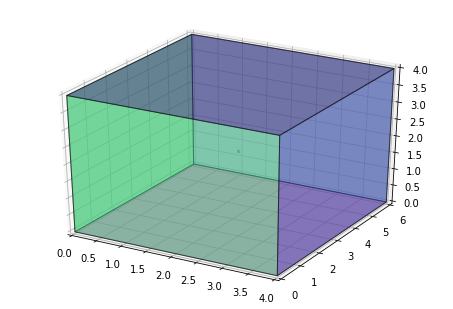

In [134]:
#Room dimensions
room_dimX, room_dimY, room_dimZ = 4, 6, 4

#Sampling frequency
fs = 16000 # 16kHz

#Microphone position
micX, micY, micZ = 2.1, 3, 2


room = pra.ShoeBox([room_dimX,room_dimY], fs=fs, max_order = 4, absorption=0.2)
room.extrude(room_dimZ)

R = np.array([[micX],[micY],[micZ]])

room.add_microphone_array(pra.MicrophoneArray(R, room.fs))


# Visualize setup
fig, ax = room.plot()
ax.set_xlim([0, 4])
ax.set_ylim([0, 6])
ax.set_zlim([0, 4]);

In [135]:
def awgn(fs, duration):
    '''Additive white gaussian noise sampled at fs for a duration of length seconds'''
    mean = 0
    std = 1 
    num_samples = fs * duration
    samples = np.random.normal(mean, std, size=num_samples)
    return samples

Create the grid for the different positions of the sound sources

In [136]:
grid_samples = (2*room_dimX+1) * (2*room_dimY+1) * (2*room_dimZ+1)
training_set = np.zeros((grid_samples))

grid1 = np.linspace(0, room_dimX, num=2*room_dimX+1)
grid2 = np.linspace(0, room_dimY, num=2*room_dimY+1)
grid3 = np.linspace(0, room_dimZ, num=2*room_dimZ+1)

In [137]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [138]:
grid = cartesian_product(grid1, grid2, grid3)

signal_train = awgn(fs=16000, duration=1) 

In [144]:
def newRoom_RIR(source_pos, source_signal, Xdim, Ydim, Zdim, mic_pos, fs):
    '''Compute the RIR of a new sound source '''
    
    #Create room
    room = pra.ShoeBox([Xdim,Ydim], fs=fs, max_order = 4, absorption=0.2)
    room.extrude(Zdim)
    
    #Add microphone
    room.add_microphone_array(pra.MicrophoneArray(mic_pos, room.fs))
    
    #Add source
    room.add_source(source_pos, signal=source_signal)
    
    room.compute_rir()
    
    return room.rir

C-extension libroom unavailable. Falling back to pure python


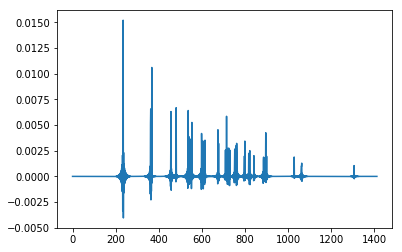

In [154]:
rir = newRoom_RIR(grid[0,:], signal_train, room_dimX, room_dimY, room_dimZ, mic_pos=np.array([[micX],[micY],[micZ]]), fs=fs)
plt.plot(rir[0][0])
plt.show()

Create the training set with the RIR of different sound source positions

In [155]:
def create_training_set(grid, signal_train, Xdim, Ydim, Zdim, mic_pos, fs):
    '''Create training dictionary by computing the Room Impulse Response of the different sound source position in the grid'''
    n_samples, _ = grid.shape
    training_set = dict()
    
    for i,pos in enumerate(grid):
        rir = newRoom_RIR(pos, signal_train, Xdim, Ydim, Zdim, mic_pos, fs)
        training_set[i] = rir
    
    return training_set

In [ ]:
train = create_training_set(grid, signal_train, Xdim=4, Ydim=6, Zdim=4, mic_pos=np.array([[micX],[micY],[micZ]]), fs=fs)

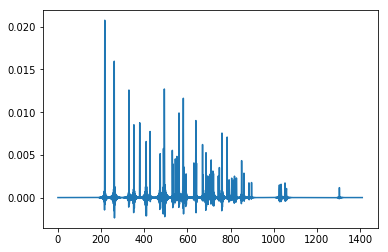

In [157]:
rir_example = train[6]
plt.plot(rir_example[0][0])
plt.show()

In [158]:
def correlate(signal1, signal2):
    corr = np.correlate(signal1, signal2)
    return corr[0]
        

def compute_similarities(rir, train, top=3):
    '''Compute the cross correlation between the test RIR with all the RIR of the training set and select the top matches rir's'''
    
    similarities = []
    for key, val in train.items():
        rir_train = val[0][0]
        similarities.append(correlate(rir, rir_train))
    
    top_array = np.array(similarities).argsort()[-top:][::-1]
    return top_array

In [181]:
_, signal = wavfile.read("test1.wav")


room = pra.ShoeBox([room_dimX,room_dimY], fs=fs, max_order = 4, absorption=0.2)
room.extrude(room_dimZ)
R = np.array([[micX],[micY],[micZ]])

room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

room.add_source([2, 3, 3], signal=signal)
source_pos = np.array([2, 3, 3])

room.compute_rir()

rir = room.rir

C-extension libroom unavailable. Falling back to pure python


In [182]:
top3 = compute_similarities(rir[0][0], train)
top3

array([524, 528, 869])

In [183]:
grid[top3,:]

array([[2. , 3. , 1. ],
       [2. , 3. , 3. ],
       [3.5, 2.5, 2.5]])

In [180]:
np.linalg.norm(grid[877,:] - source_pos)

2.0518284528683193